<a href="https://colab.research.google.com/github/juninhoisrael/analisedevinho/blob/main/Analise_vinho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neste problema vamos prever quais vinhos foram bem avaliados pelos enólogos a partir de suas propriedades químicas. Adaptado do dataset no [UCI](https://archive.ics.uci.edu/ml/datasets/wine).
Os dados já estão separadas em treino e teste nos arquivos `transf_wine_treino.csv` e `transf_wine_teste.csv`, com as seguintes features:
- `type`: Tipo do vinho (Branco ou Tinto)
- `fixed acidity`: Acidez proveniente de ácidos que não evaporam rapidamente
- `volatile acidity`: Acidez proveniente de ácidos que evaporam rapidamente
- `citric acid`: Ácido cítrico presente no vinho, dá sensação de fescor
- `residual_sugar`: Açúcar da uva residual após fermentação
- `chlorides`: Quantidade de sais presentes no vinho
- `free sulfur dioxide`: Formas livres de SO2 presentes no vinho
- `total sulfur dioxide`: Formas livres e moleculares de SO2 presentes no vinho
- `pH`: pH (acidez) do vinho
- `sulphates`: Quantidade de sulfatos no vinho
- `alcohol`: Quantidade de álcool presente no vinho
- `aprovado`: Indicativo de aprovação ou não do vinho pelos enólogos. `1` indica aprovação e `0` indica reprovação. **É nossa variável de interesse!**

In [1]:
from google.colab import drive # Caso a leitura desse código seja feito pelo Colab, será necessário importar do drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# muitas linhas e colunas de uma vez
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999 

# Carregando os dados
dados_treino = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TERA/analise de vinhos/Dados/transf_wine_treino.csv',index_col=0).drop('index',axis=1)
dados_teste = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TERA/analise de vinhos/Dados/transf_wine_teste.csv',index_col=0).drop('index',axis=1)

In [ ]:
# Primeiras linhas da base de treino
dados_treino.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,aprovado
0,white,6.7,0.41,0.27,2.6,0.033,25.0,85.0,0.99086,3.05,0.34,11.7,1
1,white,8.6,0.23,0.46,1.0,0.054,9.0,72.0,0.99410,2.95,0.49,9.1,1
2,white,6.6,0.32,0.26,4.6,0.031,26.0,120.0,0.99198,3.40,0.73,12.5,1
3,red,8.2,0.33,0.32,2.8,0.067,4.0,12.0,0.99473,3.30,0.76,12.8,1
4,white,6.9,0.28,0.24,2.1,0.034,49.0,121.0,0.98882,2.98,0.43,13.2,1


# O objetivo é selecionar vinhos com a marcação `1` (Aprovado)

In [5]:
# Selecionando manualmente os aprovados
vinhos_aprovados = dados_treino[dados_treino.aprovado==1]
# Visualizando os dados
vinhos_aprovados.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,aprovado
0,white,6.7,0.41,0.27,2.6,0.033,25.0,85.0,0.99086,3.05,0.34,11.7,1
1,white,8.6,0.23,0.46,1.0,0.054,9.0,72.0,0.99410,2.95,0.49,9.1,1
2,white,6.6,0.32,0.26,4.6,0.031,26.0,120.0,0.99198,3.40,0.73,12.5,1
3,red,8.2,0.33,0.32,2.8,0.067,4.0,12.0,0.99473,3.30,0.76,12.8,1
4,white,6.9,0.28,0.24,2.1,0.034,49.0,121.0,0.98882,2.98,0.43,13.2,1


O problema é que na maior parte dos casos não teremos essa variável de antemão, portanto precisamos descobrir como essa marcação se relaciona com `outras variáveis` da base.

### EDA

Para ter uma noção geral da base e dos tipos de dados, utilizaremos o metodo .info()

In [6]:
dados_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3820 entries, 0 to 3819
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3820 non-null   object 
 1   fixed acidity         3812 non-null   float64
 2   volatile acidity      3815 non-null   float64
 3   citric acid           3817 non-null   float64
 4   residual sugar        3819 non-null   float64
 5   chlorides             3818 non-null   float64
 6   free sulfur dioxide   3820 non-null   float64
 7   total sulfur dioxide  3820 non-null   float64
 8   density               3820 non-null   float64
 9   pH                    3813 non-null   float64
 10  sulphates             3816 non-null   float64
 11  alcohol               3820 non-null   float64
 12  aprovado              3820 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 417.8+ KB


Como temos muitas variáveis numéricas e contínuas, podemos descobrir as principais estatísticas da base usando outro método, o `.describe()`:

In [7]:
# Aplicando o método describe
dados_treino.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,aprovado
count,3812.000000,3815.000000,3817.000000,3819.000000,3818.000000,3820.000000,3820.000000,3820.000000,3813.000000,3816.000000,3820.000000,3820.000000
mean,7.234824,0.353751,0.315517,5.422427,0.057588,30.224738,115.938482,0.994884,3.215156,0.528305,10.366881,0.495026
std,1.278295,0.170932,0.148611,4.839934,0.035642,18.459657,57.503221,0.002990,0.161158,0.148777,1.166274,0.500041
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.250000,8.000000,0.000000
25%,6.400000,0.240000,0.240000,1.800000,0.039000,16.000000,76.000000,0.992660,3.110000,0.430000,9.400000,0.000000
50%,7.000000,0.300000,0.310000,2.850000,0.048000,28.000000,119.000000,0.995165,3.200000,0.500000,10.100000,0.000000
75%,7.700000,0.430000,0.400000,8.100000,0.069000,41.000000,156.000000,0.997100,3.310000,0.590000,11.100000,1.000000
max,15.900000,1.580000,1.230000,65.800000,0.610000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


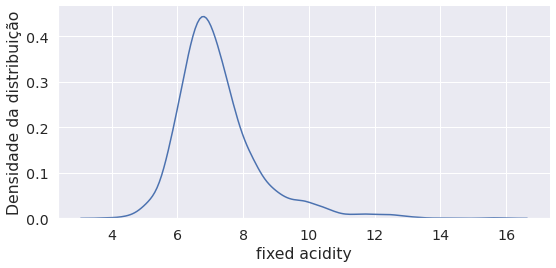

In [9]:
import seaborn as sns
sns.set(font_scale = 1.3) # Para aumentar o tamanho da fonte
coluna = 'fixed acidity' # Coluna a ser representada


sns.displot(
    dados_treino[coluna], #Dados a serem representados. Selecionamos apenas a coluna de interesse
    height=4, # Altura em polegadas do gráfico
    aspect=2, # Proporção entre largura e altura do gráfico. Números > 1 representam retâgulos mais 'deitados'
    kind='kde' # Distribuição contínua,
)
plt.ylabel('Densidade da distribuição')
plt.show()

Trocando a coluna para `alcohol`:

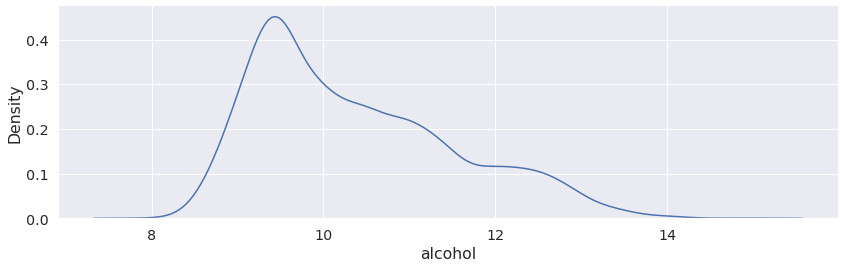

In [10]:
# Importando o módulo Seaborn
import seaborn as sns
sns.set(font_scale = 1.3) # Para aumentar o tamanho da fonte
coluna = 'alcohol' # Coluna a ser representada

# Instanciando o Displot. Só precisamos da coluna que queremos representar
sns.displot(
    dados_treino[coluna], #Dados a serem representados. Selecionamos apenas a coluna de interesse
    height=4, # Altura em polegadas do gráfico
    aspect=3, # Proporção entre largura e altura do gráfico. Números > 1 representam retâgulos mais 'deitados'
    kind='kde',

)
plt.show()

In [11]:
# Representando a variável categórica da base
dados_treino['type']

0       white
1       white
2       white
3         red
4       white
        ...  
3815      red
3816      red
3817      red
3818      red
3819      red
Name: type, Length: 3820, dtype: object

In [12]:
# Selecionando a coluna e contando registros
dados_treino.type.value_counts(normalize=True)*100

white    73.874346
red      26.125654
Name: type, dtype: float64

In [13]:
# Aplicando a mesma contagem para os dados de teste, agora normalizando
dados_teste.type.value_counts(normalize=True)

white    0.736287
red      0.263713
Name: type, dtype: float64

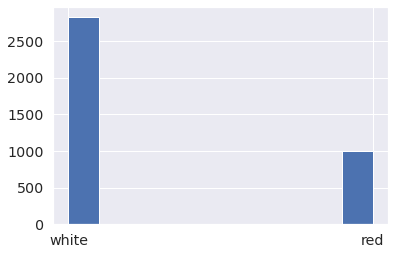

In [14]:
# Selecionando a coluna 'type' e construindo o histograma
dados_treino.type.hist()
plt.show()

### Visualizando relações entre variáveis


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


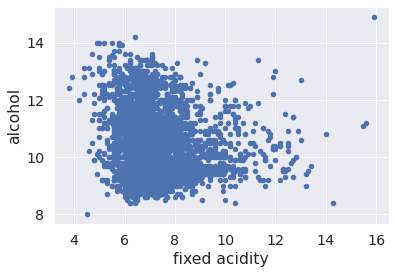

In [15]:
# Selecionando dados e representando em dispersão
dados_treino.plot(
    x='fixed acidity', # Coluna para o eixo X
    y='alcohol', # Coluna para o eixo Y
    kind='scatter' # Tipo de gráfico. Para dispersão, usamos 'scatter'
)
plt.show()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


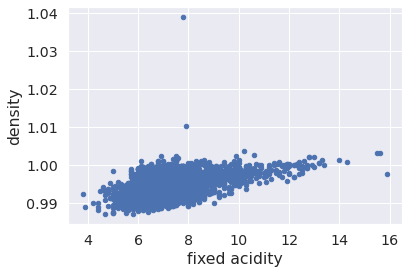

In [16]:
# Selecionando dados e representando em dispersão
dados_treino.plot(
    x='fixed acidity', # Coluna para o eixo X
    y='density', # Coluna para o eixo Y
    kind='scatter' # Tipo de gráfico. Para dispersão, usamos 'scatter'
)
plt.show()


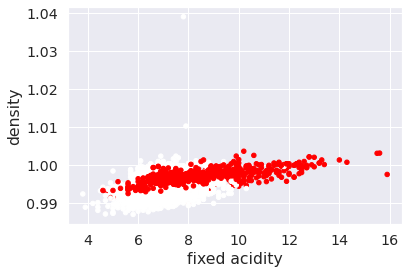

In [17]:
# Selecionando dados e representando em dispersão
dados_treino.plot(
    x='fixed acidity', # Coluna para o eixo X
    y='density', # Coluna para o eixo Y
    c='type', # Indicando que queremos diferenciar as cores (c) do gráfico pela coluna 'type'
    kind='scatter' # Tipo de gráfico. Para dispersão, usamos 'scatter'
)
plt.show()

Agora os dados de vinho tinto estão representados pelos pontos vermelhos, e os de vinho branco pelos pontos brancos.

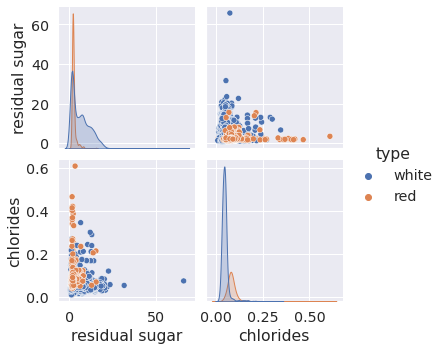

In [18]:
# Analisando as variáveis Residual Sugar, Chloirides e Free Sulfur Dioxide
sns.set_context(font_scale=0.7)
sns.pairplot(dados_treino, # Dados para plotar
             hue='type', #Cada gráfico separado pelo tipo, nossa variável categórica
            vars=['residual sugar','chlorides'] # Variáveis a serem analisadas
            )
plt.show()

Neste gráfico, temos ao mesmo tempo 
* Nos gráficos da diagonal principal, a distribuição (`displot`) da variável de interesse
* Nos gráficos fora da diagonal principal, os gráficos de dispersão entre as variáveis

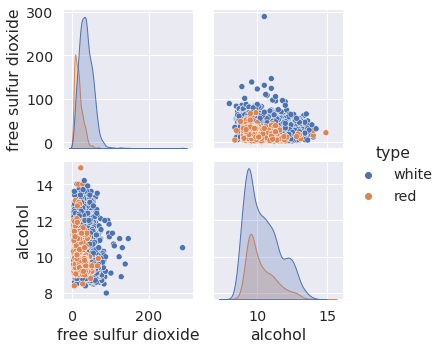

In [19]:
sns.set_context(font_scale=1.4)
sns.pairplot(dados_treino, # Dados para plotar
             hue='type', #Cada gráfico separado pelo tipo, nossa variável categórica
            vars=['free sulfur dioxide','alcohol']# Variáveis a serem analisadas
            )
plt.show()

### Relações entre variáveis

Para identificar correlações, podemos ser mais diretos e usar a matriz de correlações de Pearson do DataFrame, `.corr()`

In [20]:
# Correlações entre as features numéricas
dados_treino.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,aprovado
fixed acidity,1.000000,0.222785,0.309627,-0.115249,0.289936,-0.278518,-0.325076,0.455007,-0.254550,0.289676,-0.102279,-0.075287
volatile acidity,0.222785,1.000000,-0.388123,-0.205602,0.385803,-0.349255,-0.420528,0.278714,0.283761,0.235139,-0.049637,-0.250180
citric acid,0.309627,-0.388123,1.000000,0.175701,0.023442,0.163051,0.237000,0.100831,-0.364916,0.036574,-0.025742,0.069604
residual sugar,-0.115249,-0.205602,0.175701,1.000000,-0.128864,0.413484,0.497286,0.553032,-0.275806,-0.176995,-0.335601,-0.038862
chlorides,0.289936,0.385803,0.023442,-0.128864,1.000000,-0.181222,-0.265867,0.356728,0.037354,0.411112,-0.259419,-0.179230
free sulfur dioxide,-0.278518,-0.349255,0.163051,0.413484,-0.181222,1.000000,0.725463,0.029537,-0.159882,-0.172979,-0.160953,0.042836
total sulfur dioxide,-0.325076,-0.420528,0.237000,0.497286,-0.265867,0.725463,1.000000,0.030814,-0.256720,-0.251869,-0.253002,-0.056357
density,0.455007,0.278714,0.100831,0.553032,0.356728,0.029537,0.030814,1.000000,0.003035,0.266175,-0.669189,-0.278794
pH,-0.254550,0.283761,-0.364916,-0.275806,0.037354,-0.159882,-0.256720,0.003035,1.000000,0.186242,0.141885,0.029202
sulphates,0.289676,0.235139,0.036574,-0.176995,0.411112,-0.172979,-0.251869,0.266175,0.186242,1.000000,-0.009753,0.042009


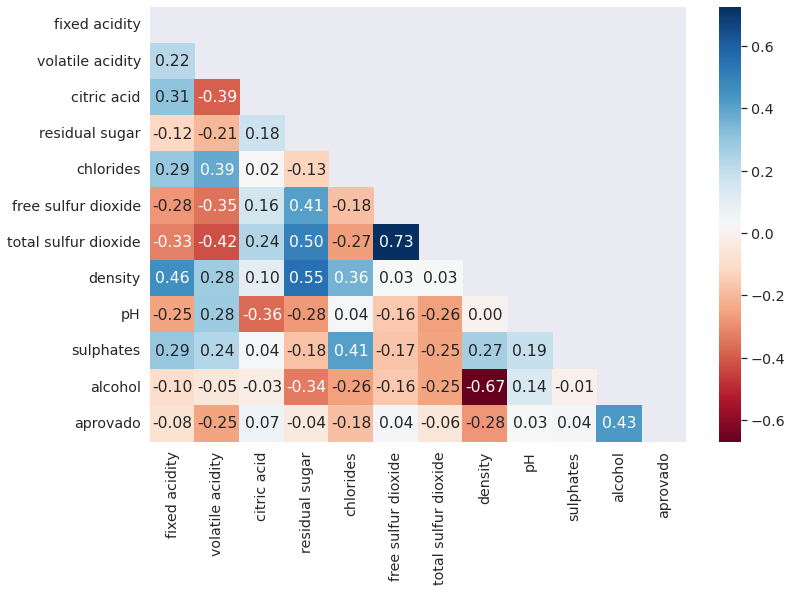

In [21]:
# Plotando a matriz de correlações usando um Heatmap para dar cor aos números
sns.set_context(font_scale=1.9)
plt.figure(figsize=(12,8))
sns.heatmap(
    dados_treino.corr(), #Fonte dos dados, nossa matriz de correlação
    annot=True, #Anotar os valores das correlações nas caixinhas coloridas
    fmt='.2f', # Formato float de 2 dígitos, para arredondar os números
    cmap='RdBu', # Mapa de cores do vermelho (menor) para o azul (maior)
    mask=np.triu( # Faz uma matriz triangular
        np.ones_like(dados_treino.corr()) # usando como base uma matriz de '1's, do mesmo tamanho que a matriz de correlação
    ) # A máscara vai então 'apagar' a diagonal superior da matriz
           )
plt.show()

A correlação entre teor alcoolico e aprovação é alta.

In [23]:
# Listando as colunas numéricas
colunas_numericas = [['fixed acidity','volatile acidity','citric acid','residual sugar'],
                    ['chlorides','free sulfur dioxide','total sulfur dioxide','density'],
                    ['pH','sulphates','alcohol','']] # Essa última célula está vazia pois temos 11 colunas numéricas

In [24]:
colunas_numericas

[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar'],
 ['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density'],
 ['pH', 'sulphates', 'alcohol', '']]

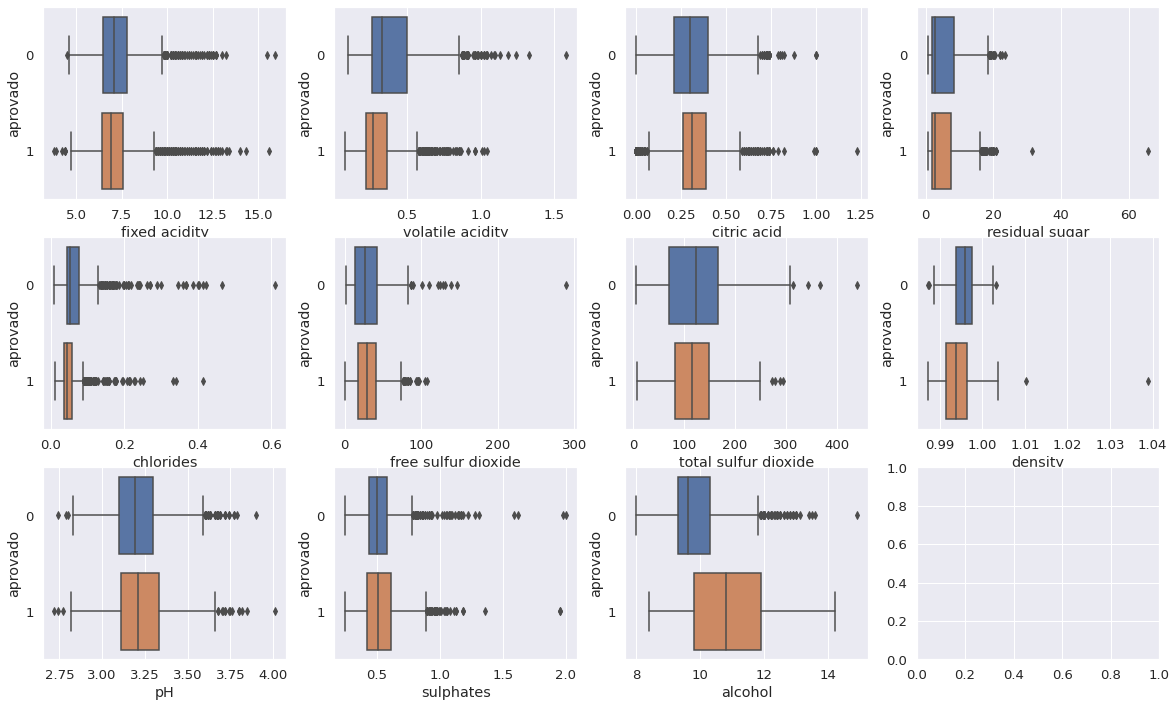

In [25]:
sns.set(font_scale=1.2)
# Cria os 'espaços' para que possamos plotar os gráficos. Faremos um grid de 3 linhas por 4 colunas (o 3,4 na função)
fig, eixo = plt.subplots(3,4,figsize=(20,12)) # Criando uma figura e 12 eixos, em uma matriz de 3 linhas x 4 colunas
# Para cada linha 
for linha in range(3):
    # Para cada coluna
    for coluna in range(4):
        # Verifica se existe um nome de coluna na lista 'colunas_numericas'
        if colunas_numericas[linha][coluna] != '':
            # Se sim faz o plot do Boxplot naquela linha e coluna, indicando no eixo vertical/y sempre a variável 'aprovado'
            sns.boxplot(data=dados_treino,x=colunas_numericas[linha][coluna],y='aprovado',ax=eixo[linha][coluna],orient='h')

### 3.1 Tratamento de missings

In [ ]:
dados_treino.isna()  

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,aprovado
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3815,False,False,False,False,False,False,False,False,False,False,False,False,False
3816,False,False,False,False,False,False,False,False,False,False,False,False,False
3817,False,False,False,False,False,False,False,False,False,False,False,False,False
3818,False,False,False,False,False,False,False,False,False,False,False,False,False


Para entender os missings por coluna, podemos calcular a média:

In [ ]:
dados_treino.isna().mean(axis=0)*100 #Multiplicando por 100 para transformar em percentual

type                    0.000000
fixed acidity           0.209424
volatile acidity        0.130890
citric acid             0.078534
residual sugar          0.026178
chlorides               0.052356
free sulfur dioxide     0.000000
total sulfur dioxide    0.000000
density                 0.000000
pH                      0.183246
sulphates               0.104712
alcohol                 0.000000
aprovado                0.000000
dtype: float64

In [27]:
dados_teste.isna().mean()

type                    0.0
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
aprovado                0.0
dtype: float64

Não temos missings nos dados de teste, e temos apenas 0.20% de missings no máximo nos dados de treino!


Em situações como essa, onde os missings representam uma baixa proporção da base, podemos apenas **excluir os registros**. Podemos fazer isso usando o método `.dropna()` do Pandas


In [26]:
dados_treino_mis = dados_treino.dropna()

# Testando para ver se excluiu mesmo
dados_treino_mis.isna().mean()

type                    0.0
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
aprovado                0.0
dtype: float64

## 4. Usando análises para encontrar os vinhos aprovados

Agora que temos um bom repositório de técnicas, vamos usá-las para tentar encontrar os melhores vinhos!

### Mas como medir o sucesso?


Se calcularmos a `média`da coluna `aprovado`, veremos o percentual de vinhos da base que são aprovados

In [28]:
# A média de uma coluna que possui '0's e '1's nos dará o percentual de '1's
dados_treino.aprovado.mean()

0.4950261780104712

Temos então **49,5%** dos vinhos aprovados. Vamos então descobrir como filtrar vinhos aprovados baseados nas outras propriedades

In [29]:
# Fazendo apenas o groupby, o que o Python retorna é um agrupamento
dados_treino.groupby('type')

In [30]:
dados_treino.groupby('type')['aprovado'].mean() # Média da coluna 'agrupado' pela variável 'type'

type
red      0.406814
white    0.526223
Name: aprovado, dtype: float64

Baseado nesta avaliação, qual tipo de vinho parece ter maior aprovação? Vinho Branco

In [31]:
# Separando uma variável contínua em faixas
coluna = 'chlorides'

# Criando uma nova coluna que é a faixa da coluna 'chlorides'

dados_treino[coluna+'_faixa'] = pd.cut(
    dados_treino[coluna], # Coluna de interesse
    bins=5 # Número de faixas
)
# Se quiser cortar em quantis, usar o pd.qcut

Com a faixa da coluna criada, podemos usar a mesma lógica do `.groupby()`

In [32]:
# Executando o .groupby() da coluna criada
agrupamento = dados_treino.groupby('chlorides_faixa')['aprovado'].agg(['count','mean'])
# Renomeando colunas
agrupamento.columns = ['contagem','fração vinhos aprovados']
agrupamento

,contagem,fração vinhos aprovados
chlorides_faixa,,
"(0.0084, 0.129]",3717,0.500404
"(0.129, 0.249]",81,0.320988
"(0.249, 0.37]",12,0.250000
"(0.37, 0.49]",7,0.142857
"(0.49, 0.61]",1,0.000000


Baseado nesta seleção, qual faixa da coluna `chlorides` parece ser mais promissora para selecionar vinhos aprovados?

Repetindo a lógica para a coluna `alcohol`

In [ ]:
# Replicando o raciocínio com outra coluna
coluna = 'alcohol'

# Criando uma nova coluna que é a faixa da coluna 'chlorides'

dados_treino[coluna+'_faixa'] = pd.cut(
    dados_treino[coluna], # Coluna de interesse
    bins=5 # Número de faixas
)

# Executando o .groupby() da coluna criada
agrupamento = dados_treino.groupby(coluna+'_faixa')['aprovado'].agg(['count','mean'])
# Renomeando colunas
agrupamento.columns = ['contagem','fração vinhos aprovados']
agrupamento

Qual é a melhor faixa de seleção para a coluna `alcohol`?

### Automatizando o processo de seleção

Para automatizar o processo, podemos criar algumas regras de melhores faixas. Para temos uma quantidade interessante de vinhos, podemos escolher as seguintes regras para `cada coluna`:
* Faixas que tenham um número mínimo de vinhos
* Dentre as faixas acima, escolher aquela que tenha a maior fração de vinhos aprovados

Vamos então construir a lógica de seleção! Começando pela variável `chlorides`:

#### Passo 1 - Selecionar a variável e fazer a coluna de faixas

In [34]:
coluna = 'chlorides'
minimo_vinhos = 50

# Passo 1 - Selecionar a variável e fazer a coluna de faixas
dados_treino[coluna+'_faixa'] = pd.cut(dados_treino[coluna],bins=5)
dados_treino.head() 

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,aprovado,chlorides_faixa,alcohol_faixa
0,white,6.7,0.41,0.27,2.6,0.033,25.0,85.0,0.99086,3.05,0.34,11.7,1,"(0.0084, 0.129]","(10.76, 12.14]"
1,white,8.6,0.23,0.46,1.0,0.054,9.0,72.0,0.99410,2.95,0.49,9.1,1,"(0.0084, 0.129]","(7.993, 9.38]"
2,white,6.6,0.32,0.26,4.6,0.031,26.0,120.0,0.99198,3.40,0.73,12.5,1,"(0.0084, 0.129]","(12.14, 13.52]"
3,red,8.2,0.33,0.32,2.8,0.067,4.0,12.0,0.99473,3.30,0.76,12.8,1,"(0.0084, 0.129]","(12.14, 13.52]"
4,white,6.9,0.28,0.24,2.1,0.034,49.0,121.0,0.98882,2.98,0.43,13.2,1,"(0.0084, 0.129]","(12.14, 13.52]"


#### Passo 2 - Agrupar pela coluna de faixas e calcular média da coluna 'aprovado', bem como a contagem

In [46]:
# Passo 2 - Agrupar pela coluna de faixas e calcular média da coluna 'aprovado'
agrupamento = dados_treino.groupby(coluna+'_faixa')['aprovado'].agg(['count','mean'])
agrupamento.columns = ['contagem','fração vinhos aprovados']
agrupamento

,contagem,fração vinhos aprovados
chlorides_faixa,,
"(0.0084, 0.0691]",2892,0.540802
"(0.0691, 0.129]",825,0.358788
"(0.129, 0.189]",58,0.275862
"(0.189, 0.249]",23,0.434783
"(0.249, 0.31]",6,0.166667
"(0.31, 0.37]",6,0.333333
"(0.37, 0.43]",6,0.166667
"(0.43, 0.49]",1,0.000000
"(0.49, 0.55]",0,NaN


#### Passo 3 - Selecionar apenas as faixas com um número mínimo de vinhos

In [36]:
# Passo 3 - Selecionar apenas as faixas com um número mínimo de vinhos
agrupamento_filtro = agrupamento[agrupamento['contagem']>=minimo_vinhos]
agrupamento_filtro

,contagem,fração vinhos aprovados
chlorides_faixa,,
"(0.0084, 0.129]",3717,0.500404
"(0.129, 0.249]",81,0.320988


#### Passo 4 - Ordenar pela fração de vinhos aprovados, e selecionar a melhor faixa (índice 0)

In [37]:
agrupamento_filtro.sort_values(by='fração vinhos aprovados',ascending=False)

,contagem,fração vinhos aprovados
chlorides_faixa,,
"(0.0084, 0.129]",3717,0.500404
"(0.129, 0.249]",81,0.320988


In [38]:
# Passo 4 - Ordenar pela fração de vinhos aprovados, e selecionar a melhor faixa (índice 0)
faixa_final = agrupamento_filtro.sort_values(by='fração vinhos aprovados',ascending=False).iloc[0]
faixa_final

contagem                   3717.000000
fração vinhos aprovados       0.500404
Name: (0.0084, 0.129], dtype: float64

#### Passo 5 - Transformar a seleção em um DataFrame para simplificar o resultado

In [39]:
# Passo 5 - Transformar a seleção em um DataFrame para simplificar o resultado
faixa_final = faixa_final.to_frame().T # o 'to_frame' transforma em DataFrame, e o .T transpõe o DataFrame

# Imprimindo a coluna e a faixa
faixa_final

,contagem,fração vinhos aprovados
"(0.0084, 0.129]",3717.0,0.500404


In [40]:
coluna = 'chlorides'
minimo_vinhos = 50

# Passo 1 - Selecionar a variável e fazer a coluna de faixas
dados_treino[coluna+'_faixa'] = pd.cut(dados_treino[coluna],bins=5)

# Passo 2 - Agrupar pela coluna de faixas e calcular média da coluna 'aprovado'
agrupamento = dados_treino.groupby(coluna+'_faixa')['aprovado'].agg(['count','mean'])
agrupamento.columns = ['contagem','fração vinhos aprovados']

# Passo 3 - Selecionar apenas as faixas com um número mínimo de vinhos
agrupamento_filtro = agrupamento[agrupamento['contagem']>=minimo_vinhos]

# Passo 4 - Ordenar pela fração de vinhos aprovados, e selecionar a melhor faixa (índice 0)
faixa_final = agrupamento_filtro.sort_values(by='fração vinhos aprovados',ascending=False).iloc[0]

# Passo 5 - Transformar a seleção em um DataFrame para simplificar o resultado
faixa_final = faixa_final.to_frame().T # o 'to_frame' transforma em DataFrame, e o .T transpõe o DataFrame

# Imprimindo a coluna e a faixa
faixa_final

,contagem,fração vinhos aprovados
"(0.0084, 0.129]",3717.0,0.500404


In [41]:
faixa_final

,contagem,fração vinhos aprovados
"(0.0084, 0.129]",3717.0,0.500404


In [42]:
# Reinicializando o índice
faixa_final = faixa_final.reset_index() # Para transformar a faixa em uma coluna separada, que chamararemos de 'melhor faixa'
# Renomeando colunas
faixa_final.columns = ['melhor faixa','contagem','fração vinhos aprovados']
# Criando uma nova coluna que terá o nome da variável analisada
faixa_final['coluna'] = coluna
# Colocando esta coluna coim o nome da variável como índice
faixa_final.set_index('coluna',inplace=True)

faixa_final

,melhor faixa,contagem,fração vinhos aprovados
coluna,,,
chlorides,"(0.0084, 0.129]",3717.0,0.500404


In [43]:
def seleciona_faixa(dados, coluna, min_vinhos=100, faixas=10):
    # Função que parte dos dados e da coluna, selecionando a melhor faixa dentre as faixas escolhidas 
    # Passo 1 - Selecionar a variável e fazer a coluna de faixas
    dados_treino[coluna+'_faixa'] = pd.cut(dados_treino[coluna],bins=faixas)
    # Passo 2 - Agrupar pela coluna de faixas e calcular média da coluna 'aprovado'
    agrupamento = dados_treino.groupby(coluna+'_faixa')['aprovado'].agg(['count','mean'])
    agrupamento.columns = ['contagem','fração vinhos aprovados']
    # Passo 3 - Selecionar apenas as faixas com um número mínimo de vinhos
    agrupamento_filtro = agrupamento[agrupamento['contagem']>=min_vinhos]
    # Passo 4 - Ordenar pela fração de vinhos aprovados, e selecionar a melhor faixa
    faixa_final = agrupamento_filtro.sort_values(by='fração vinhos aprovados',ascending=False).reset_index().iloc[0].to_frame().T
    # Ajustando nomes
    faixa_final.columns = ['faixa','contagem','fração vinhos aprovados']
    # Criando uma nova coluna com o nome da variável testada, e colocando-a como índice
    faixa_final['coluna'] = coluna
    faixa_final.set_index('coluna',inplace=True)
    # Salvando as seleções em um dataframe
    return faixa_final
    # Não vamos retornar nada nessa função

In [44]:
# Rodando para a primeira coluna
teste_faixas = seleciona_faixa(dados_treino,'chlorides')

In [45]:
# Novamente selecionando as colunas numéricas
colunas_numericas = list(dados_treino.select_dtypes(include='float').columns)

# Rodando a função para todas as colunas (excluindo a 'chlorides', que já fizemos)
for col in colunas_numericas[1:]:
    teste_faixas = pd.concat([teste_faixas,seleciona_faixa(dados_treino,col)])
teste_faixas

,faixa,contagem,fração vinhos aprovados
coluna,,,
chlorides,"(0.0084, 0.0691]",2892,0.540802
volatile acidity,"(0.0785, 0.23]",800,0.69125
citric acid,"(0.246, 0.369]",1574,0.604828
residual sugar,"(0.535, 7.12]",2679,0.513251
chlorides,"(0.0084, 0.0691]",2892,0.540802
free sulfur dioxide,"(29.8, 58.6]",1507,0.555408
total sulfur dioxide,"(92.8, 136.2]",1158,0.596718
density,"(0.987, 0.992]",820,0.77439
pH,"(3.365, 3.494]",451,0.545455


In [ ]:
# Ordenando pela melhor fração de aprovação
teste_faixas.sort_values(by='fração vinhos aprovados',ascending=False) #Ascending=False indica ordenação decrescente

,faixa,contagem,fração vinhos aprovados
coluna,,,
alcohol,"(12.14, 12.83]",287,0.926829
density,"(0.987, 0.992]",820,0.77439
sulphates,"(0.775, 0.95]",169,0.698225
volatile acidity,"(0.0785, 0.23]",800,0.69125
citric acid,"(0.246, 0.369]",1574,0.604828
total sulfur dioxide,"(92.8, 136.2]",1158,0.596718
free sulfur dioxide,"(29.8, 58.6]",1507,0.555408
pH,"(3.365, 3.494]",451,0.545455
chlorides,"(0.0084, 0.0691]",2892,0.540802


Vamos agora testar essa mesma regra na nossa `base de teste`, e verificar se nossas conclusões são consistentes!

In [ ]:
# Lembrando as faixas de corte
teste_faixas.loc['alcohol']

faixa                      (12.14, 12.83]
contagem                              287
fração vinhos aprovados          0.926829
Name: alcohol, dtype: object

In [ ]:
# Fazendo o mesmo corte na base de teste
filtro_teste = dados_teste[dados_teste.alcohol.between(12.14,12.83)]

# Média de vinhos aprovados
print("Média de vinhos aprovados com este filtro:")
print(filtro_teste.aprovado.mean())

Média de vinhos aprovados com este filtro:
0.9402985074626866


### <center> Mais de **94% de vinhos aprovados!!!**